In this notebook we will see the basics of how to use MiniSom.

Let's start importing MiniSom:

In [1]:
from minisom import MiniSom

MiniSom relies on the Python ecosystem to import and preprocess the data. For this example we will load the famous Iris dataset using numpy:

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                    names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove', 'target'], sep='\t+')
target = data['target'].values
data = data[data.columns[:-1]]
# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

<ipython-input-2-f148bc12df82>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',


We can initialize and train MiniSom as follows:

In [3]:
# Initialization and training
n_neurons = 9
m_neurons = 9
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)

som.pca_weights_init(data)
som.train(data, 1000, verbose=True)  # random training

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.6426435848319221


To visualize the result of the training we can plot the distance map (U-Matrix) using a pseudocolor where the neurons of the maps are displayed as an array of cells and the color represents the (weights) distance from the neighbour neurons. On top of the pseudo color we can add markers that repesent the samples mapped in the specific cells:

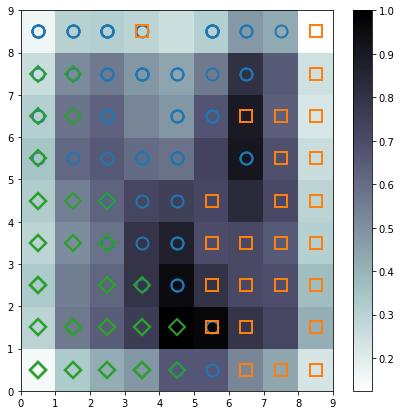

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(7, 7))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]-1], markersize=12, markeredgewidth=2)

plt.savefig('resulting_images/som_seed.png')
plt.show()

To have an idea of which neurons of the map are activated more ofted we can create another pseudocolor plot that reflects the activation frequencies:

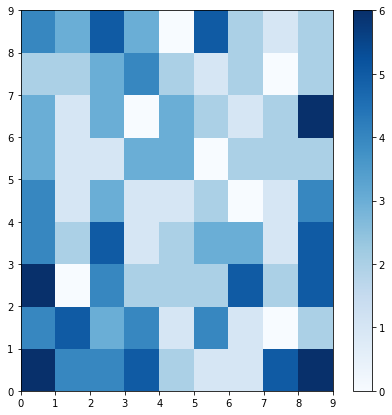

In [5]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

Wehn dealing with a supervised problem, one can visualize the proportion of samples per class falling in a specific neuron using a pie chart per neuron:

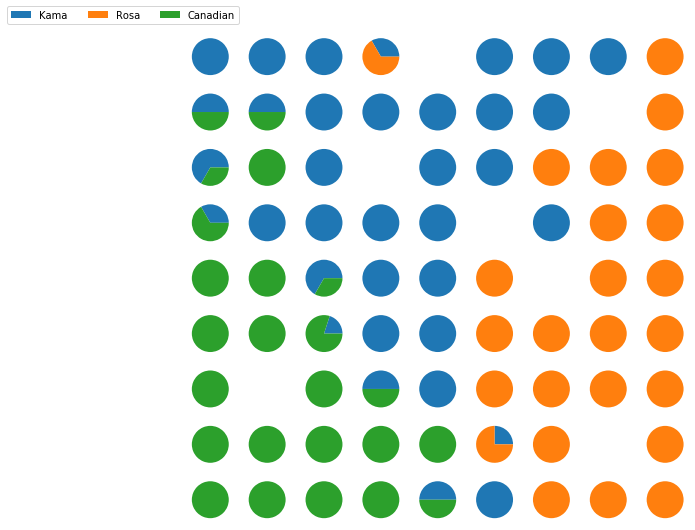

In [7]:
import matplotlib.gridspec as gridspec

label_names = {1:'Kama', 2:'Rosa', 3:'Canadian'}
labels_map = som.labels_map(data, [label_names[t] for t in target])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(0., 6.5), ncol=3)
plt.savefig('resulting_images/som_seed_pies.png')
plt.show()

To understand how the training evolves we can plot the quantization and topographic error of the SOM at each step. This is particularly important when estimating the number of iterations to run:

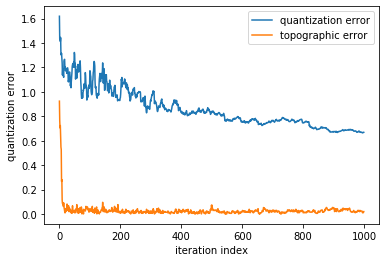

In [104]:
som = MiniSom(10, 20, data.shape[1], sigma=3., learning_rate=.7,
              neighborhood_function='gaussian', random_seed=10)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('quantization error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

Notice that in the snippet above weto run each learning iteration in a for loop and saved the errors in separated lists.